In [15]:
# Import Library
import numpy as np 
import pandas as pd 
import zipfile
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [16]:
# Import Library
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

In [17]:
# Connect ke Drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Load data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/home-credit-default-risk.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [19]:
# Load train data
train_df = pd.read_csv("/tmp/application_train.csv")
print('Training data contains {} rows and {} columns '.format(train_df.shape[0],train_df.shape[1]))

Training data contains 307511 rows and 122 columns 


In [20]:
# Visualisasi Target
px.histogram(train_df, x='TARGET', color='TARGET',title='Pembayaran Sulit vs Pembayaran Lancar')

<h3> DATA CLEANING <h3>

In [21]:
# Fungsi untuk mencari nilai yang kosong (missing value)
def missing_values(df):
    n_miss_val = df.isnull().sum()
    n_miss_per = 100 * df.isnull().sum() / len(df)
    miss_tbl = pd.concat([n_miss_val,n_miss_per],axis=1).sort_values(1,ascending=False).round(1)
    miss_tbl = miss_tbl[miss_tbl[1] !=0]
    
    miss_tbl = miss_tbl.rename(columns ={0: 'Missing Values',1:'%(Percentage) Missing Values'})
    print("{} columns that have missing values.".format(miss_tbl.shape[0]))
    
    return miss_tbl

In [22]:
# Cek missing value di data train
missing_values_table = missing_values(train_df)
missing_values_table

64 columns that have missing values.


,Missing Values,%(Percentage) Missing Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
...,...,...
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.3
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3
EXT_SOURCE_2,660,0.2


In [23]:
# Data kategori
def categorical_features(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    types=df[categorical_cols].dtypes
    uniques = df[categorical_cols].nunique()
    categorical_tbl = pd.concat([uniques,types],axis=1).sort_values(0,ascending=False).rename(columns = {0:'Unique Values',1:'Data Types'})
    print("The dataset contains {} categorical values".format(df[categorical_cols].shape[1]))
    
    return categorical_tbl

In [24]:
categorical_features(train_df)

The dataset contains 16 categorical values


,Unique Values,Data Types
ORGANIZATION_TYPE,58,object
OCCUPATION_TYPE,18,object
NAME_INCOME_TYPE,8,object
NAME_TYPE_SUITE,7,object
WEEKDAY_APPR_PROCESS_START,7,object
WALLSMATERIAL_MODE,7,object
NAME_FAMILY_STATUS,6,object
NAME_HOUSING_TYPE,6,object
NAME_EDUCATION_TYPE,5,object
FONDKAPREMONT_MODE,4,object


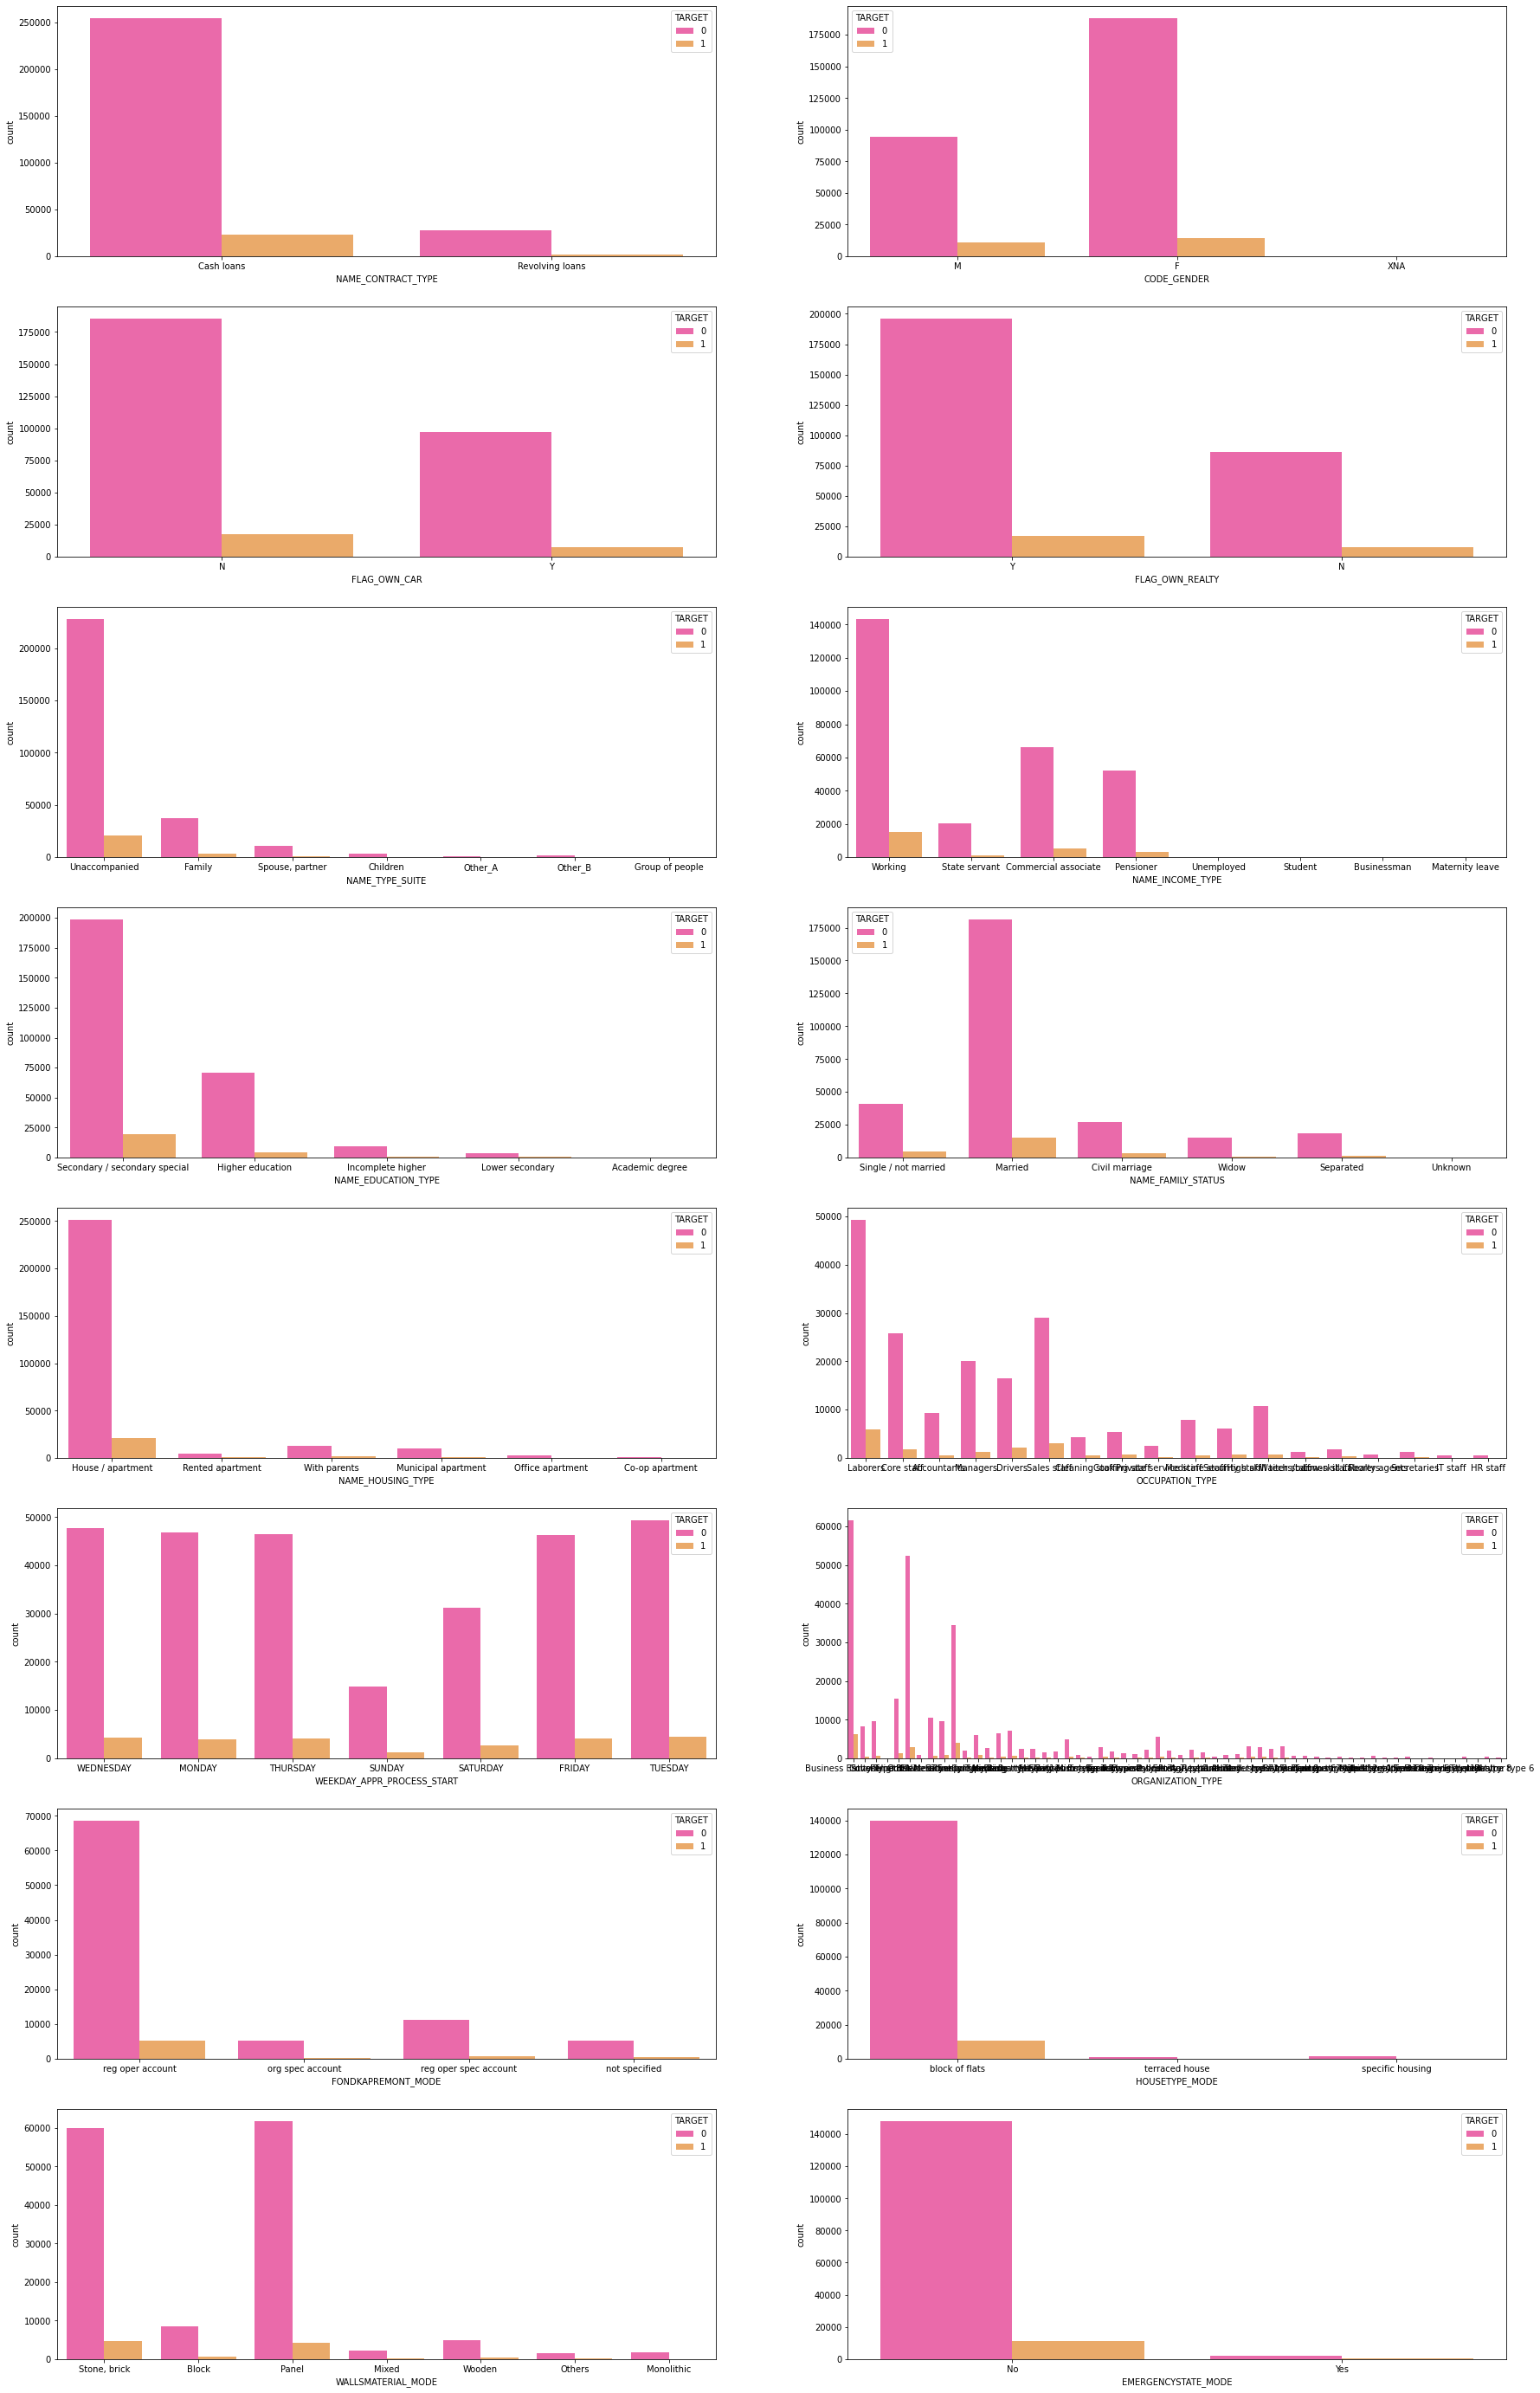

In [25]:
# Visualisasi Data Kategori
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
fig , axs = plt.subplots(ncols=2,nrows=8,figsize=(30,50))
index=0
axs = axs.flatten()
for cols in categorical_cols:
        g = sns.countplot(x=cols,hue='TARGET',data=train_df,ax=axs[index],palette="spring")
        index +=1

In [26]:
# Data Numerik
def numerical_features(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_tbl = pd.DataFrame(train_df[numerical_cols].dtypes).rename(columns = {0:'Data Types'})
    print("The dataset contains {} numerical values.(included target value)".format(df[numerical_cols].shape[1]))
    
    return numerical_tbl

In [27]:
numerical_features(train_df)

The dataset contains 106 numerical values.(included target value)


,Data Types
SK_ID_CURR,int64
TARGET,int64
CNT_CHILDREN,int64
AMT_INCOME_TOTAL,float64
AMT_CREDIT,float64
...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64
AMT_REQ_CREDIT_BUREAU_WEEK,float64
AMT_REQ_CREDIT_BUREAU_MON,float64
AMT_REQ_CREDIT_BUREAU_QRT,float64


In [28]:
# Label Encoding untuk enkode data kategori yang memiliki 1 atau 2 kategori
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

categorical_cols = train_df.select_dtypes(include=["object"])
for col in categorical_cols:
    if len(list(categorical_cols[col].unique())) <=2:
            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])

In [29]:
# Hot Encoder untuk enkode data kategori yang memiliki lebih dari 2 kategori. 
# Menggunakan fungsi get_dummies untuk mengubah data kategori menjadi data dummy
train_df= pd.get_dummies(train_df)

print('Train data : ', train_df.shape)

Train data :  (307511, 243)


In [30]:
# Korelasi semua fitur terhadap fitur TARGET
corrs = train_df.corr()['TARGET'].sort_values(ascending=False)
corr_top_df=pd.DataFrame(corrs.head(20))
corr_top_df

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
NAME_INCOME_TYPE_Working,0.057481
DAYS_LAST_PHONE_CHANGE,0.055218
CODE_GENDER_M,0.054713
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special,0.049824


In [31]:
# Mencari collinearity yaitu mencari dua atau lebih fitur yang korelasinya sangat tinggi
corr_matrix = pd.DataFrame(train_df).corr()
corr_df = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
corr_df = corr_df.unstack().reset_index()
corr_df.columns = ['Feature_1','Feature_2','Correlation']
corr_df.dropna(subset=['Correlation'],inplace=True)
corr_df['Correlation'] = round(corr_df['Correlation'],3)
corr_df['Correlation'] = abs(corr_df['Correlation'])
mtrx = corr_df.sort_values(by = 'Correlation', ascending = False)
mx_corr = mtrx[mtrx['Correlation'] > 0.75]
print('{} highly correlated features were found.'.format(mx_corr.shape[0]))
mx_corr.sample(10)

127 highly correlated features were found.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,Feature_1,Feature_2,Correlation
13650,FLOORSMAX_MODE,FLOORSMAX_AVG,0.986
11947,APARTMENTS_MODE,ELEVATORS_AVG,0.806
16569,ELEVATORS_MEDI,LIVINGAPARTMENTS_AVG,0.809
14382,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_AVG,0.970
15349,APARTMENTS_MEDI,ELEVATORS_AVG,0.835
18751,TOTALAREA_MODE,ELEVATORS_AVG,0.845
12430,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_AVG,0.972
16559,ELEVATORS_MEDI,APARTMENTS_AVG,0.835
11218,LIVINGAREA_AVG,ELEVATORS_AVG,0.868
13171,ELEVATORS_MODE,APARTMENTS_MODE,0.826


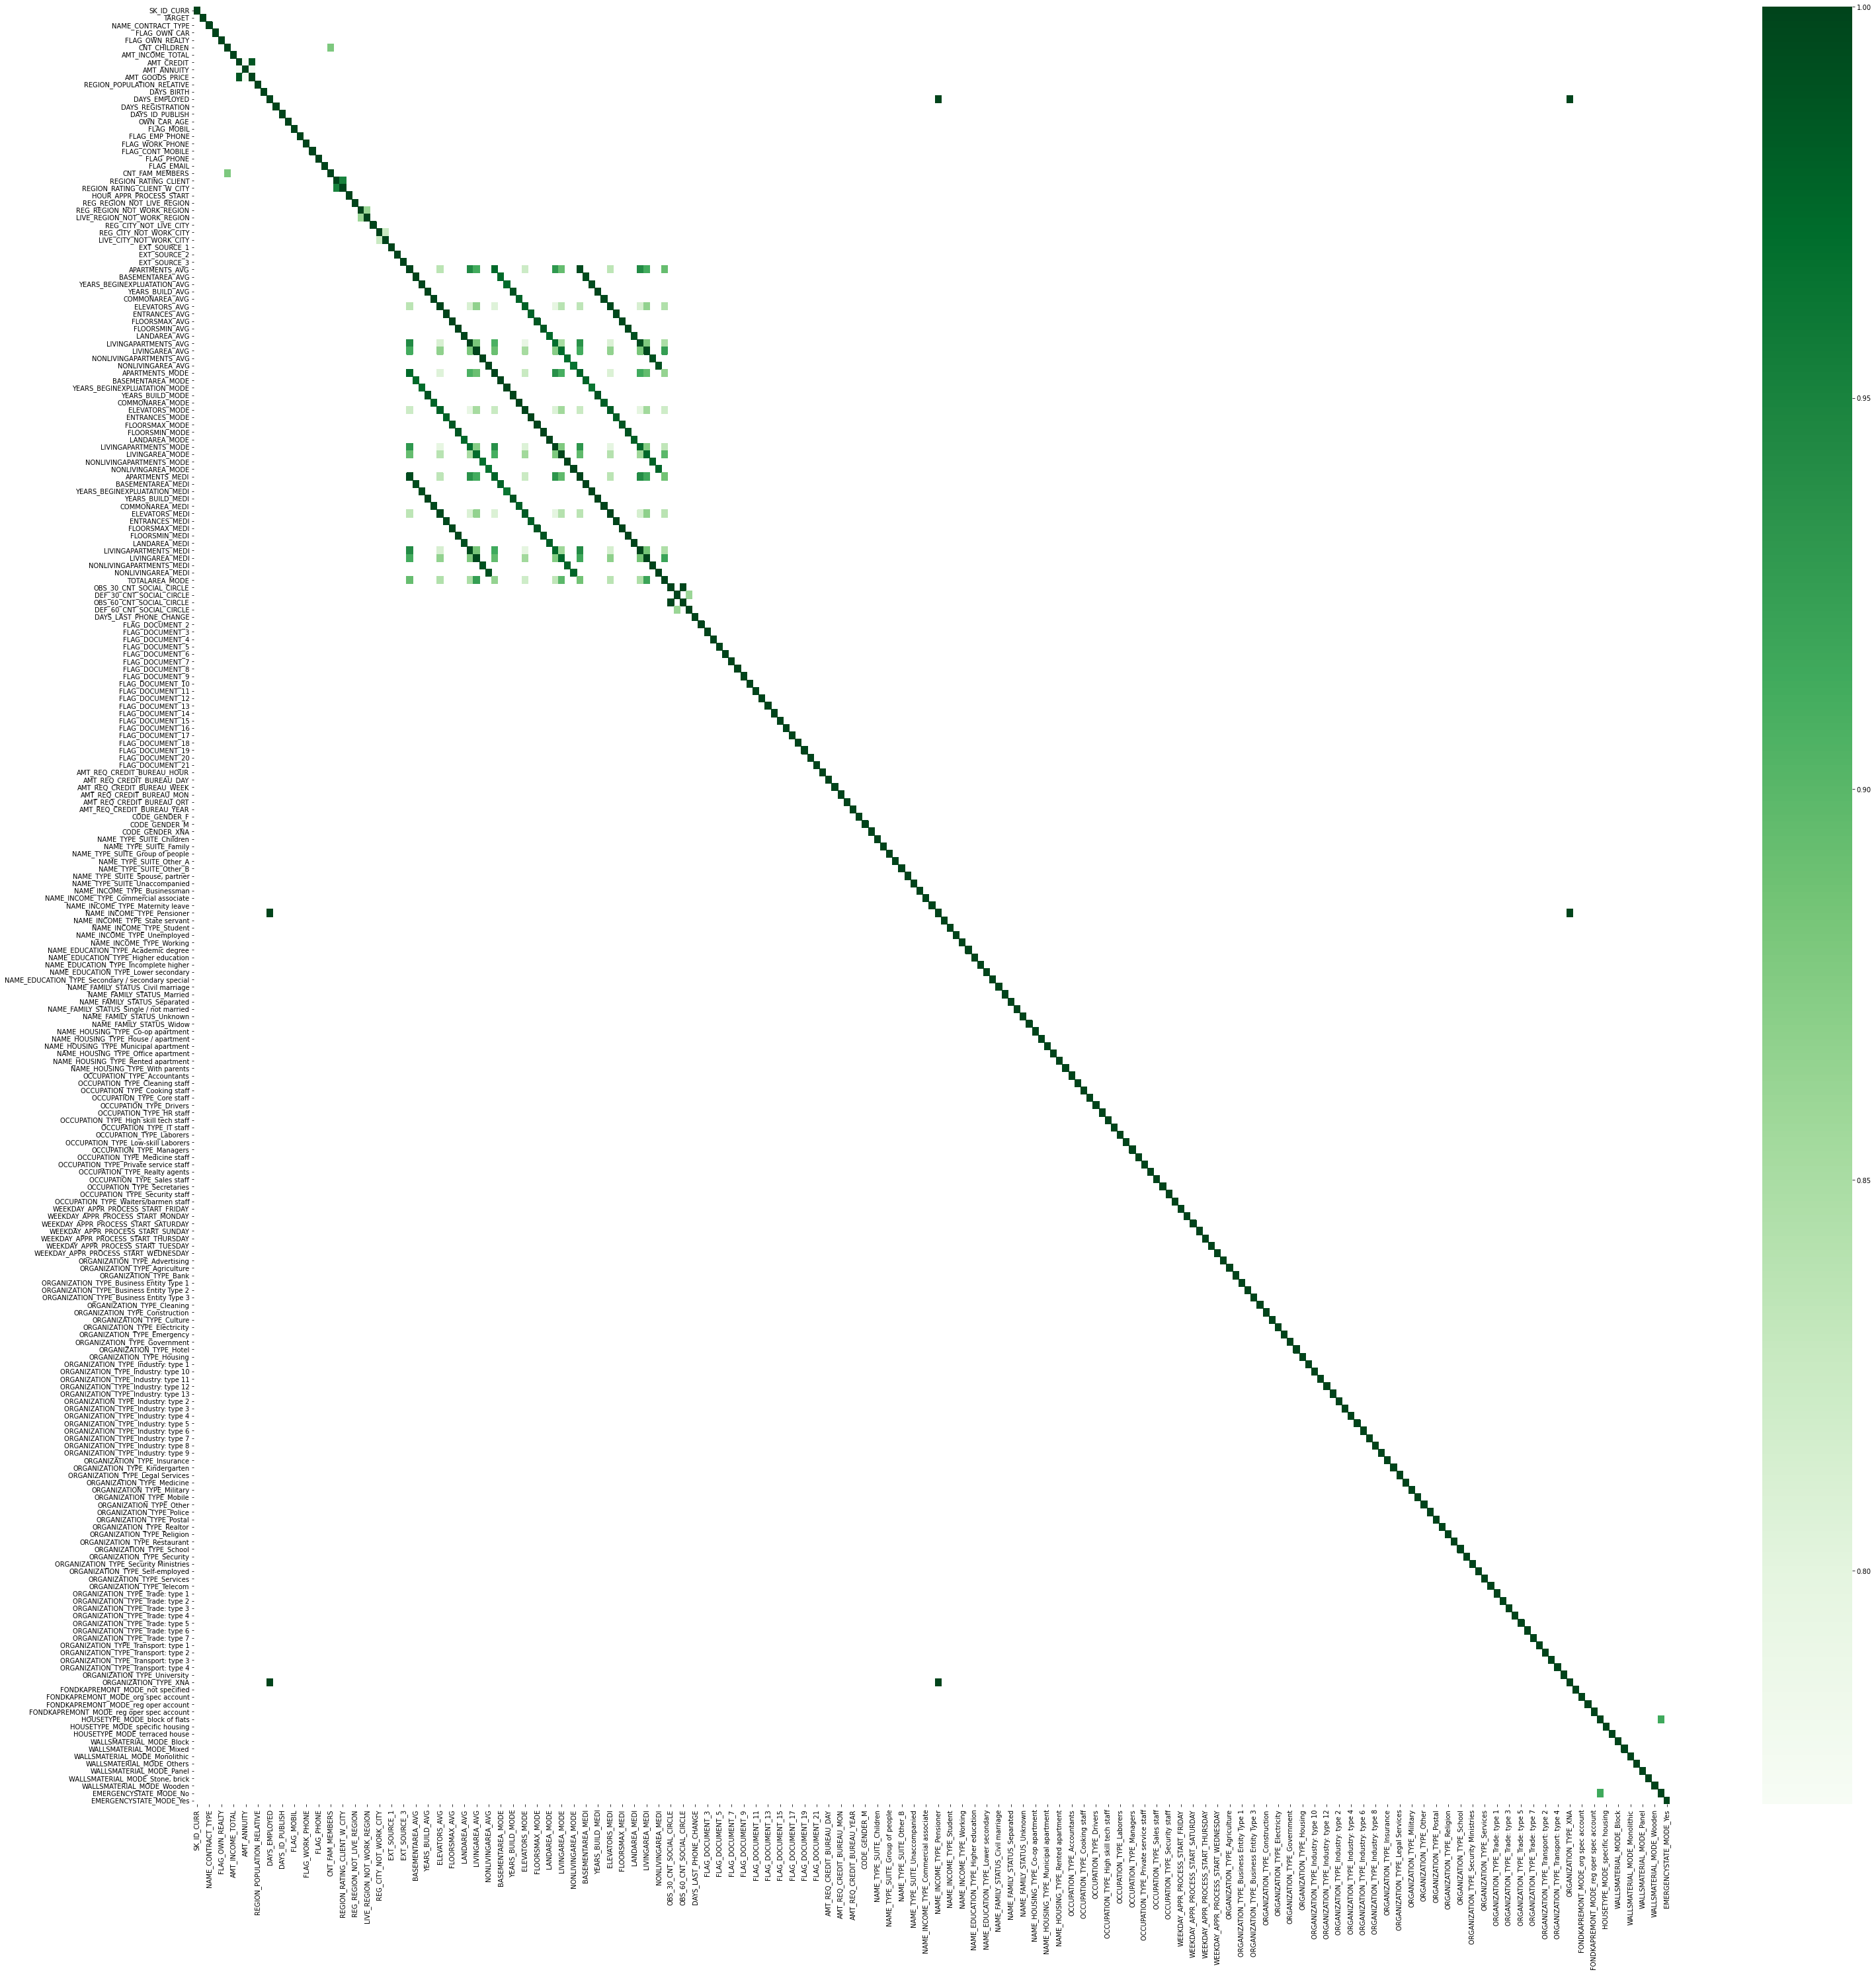

In [32]:
# Visualisasi matriks collinearity
corr= train_df.corr()
kot = corr[corr>=.75]
plt.figure(figsize=(50,50))
sns.heatmap(kot,cmap="Greens");

In [33]:
# Fitur dengan nilai collinearity
colls=mx_corr['Feature_1'].unique()

In [34]:
# Menghapus fitur collinearity
train_df = train_df.drop(train_df[colls], axis = 1)
print('Training Features shape:',train_df.shape)

Training Features shape: (307511, 196)


In [35]:
# Mencari fitur yang mempunyai nilai korelasi tinggi terhadap fitur TARGET 
target_corr = train_df.corr()['TARGET']
top_features = target_corr[(target_corr>-0.05) & (target_corr<0.05)]
train_df.drop(top_features.index,axis=1,inplace=True)
print('Training Features shape:',train_df.shape)

Training Features shape: (307511, 12)


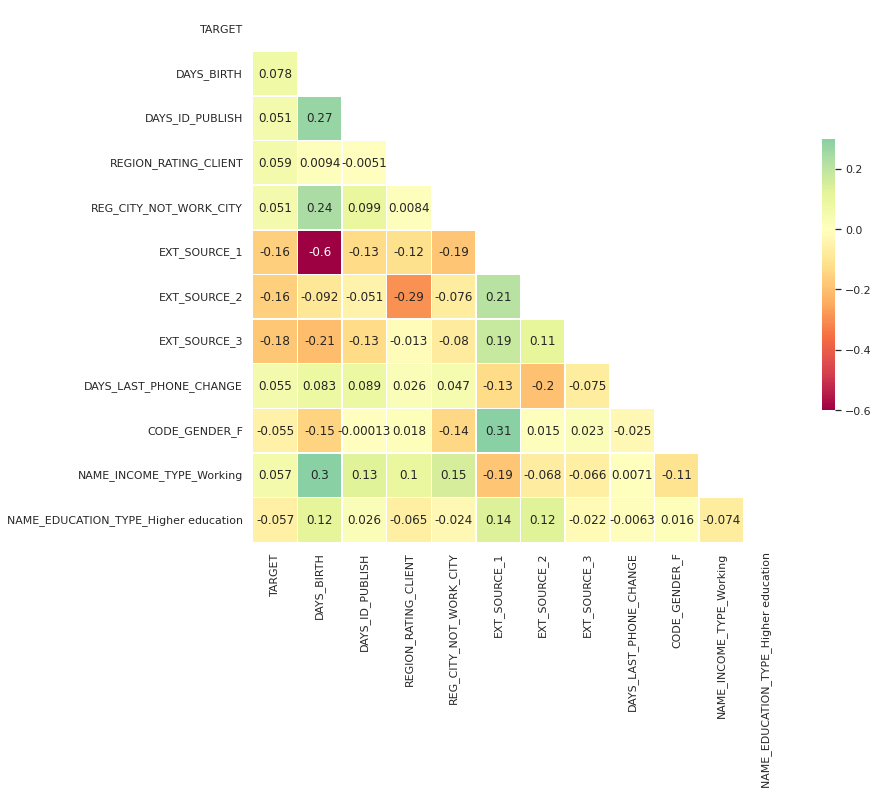

In [36]:
# Visualisasi matriks korelasi terhadap fitur TARGET
sns.set_theme(style="white")
mask = np.triu(np.ones_like(train_df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(12, 10))
cmap =sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(train_df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True);

In [37]:
# Cek missing value
nan_cols=list(train_df.isnull().columns)
nan_cols

['TARGET',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education']

In [38]:
# Mengisi missing value menggunakan SimpleImputer 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan,strategy='mean')
imp.fit(train_df[nan_cols])
train_df[nan_cols] = imp.transform(train_df[nan_cols])

<h3> DATA PREPARATION <h3>

In [39]:
# Split data latih dan data uji 
X ,y = (train_df.drop(['TARGET'],axis=1).values,train_df.TARGET.values)
print('Training Features shape:',X.shape)

Training Features shape: (307511, 11)


In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)
print('X_train Features shape:',X_train.shape)
print('X_test Features shape:',X_test.shape)
print('y_train Features shape:',y_train.shape)
print('y_test Features shape:',y_test.shape)

X_train Features shape: (206032, 11)
X_test Features shape: (101479, 11)
y_train Features shape: (206032,)
y_test Features shape: (101479,)


<h3> MODELING <h3>

In [41]:
# Fungsi model
def predict(chosed_model,name="Model"):
    mdl = chosed_model
    mdl = mdl.fit(X_train,y_train)
    y_prob = mdl.predict_proba(X_test)[:,1]
    y_pred = mdl.predict(X_test)

    print("Performances with {}".format(name))
    auc_test = round(roc_auc_score(y_test,y_prob),2)
    print("AUC Performance: ", auc_test)
    accuracy_test = round(accuracy_score(y_test, y_pred),2)
    print("Accuracy Performance: ", accuracy_test)
    recall_test = round(recall_score(y_test, y_pred, average='weighted'),2)
    print("Recall Performance: ", recall_test)
    precision_test = round(precision_score(y_test, y_pred, average='weighted', zero_division=1),2)
    print("Precision Performance: ", precision_test)
    f1_score_test = round(f1_score(y_test, y_pred, average='weighted'),2)
    print("f1_score Performance: ", f1_score_test)

In [42]:
# Model Logistic Regression
predict((LogisticRegression(max_iter=200)),'LogisticRegression')

Performances with LogisticRegression
AUC Performance:  0.72
Accuracy Performance:  0.92
Recall Performance:  0.92
Precision Performance:  0.87
f1_score Performance:  0.88


In [43]:
# Model Decision Tree 
predict((DecisionTreeClassifier(criterion='gini')),'DecisionTreeClassifier')

Performances with DecisionTreeClassifier
AUC Performance:  0.54
Accuracy Performance:  0.85
Recall Performance:  0.85
Precision Performance:  0.86
f1_score Performance:  0.86


In [44]:
# Model Random Forest
predict((RandomForestClassifier(max_depth=4 , random_state=0)),'RandomForestClassifier')

Performances with RandomForestClassifier
AUC Performance:  0.72
Accuracy Performance:  0.92
Recall Performance:  0.92
Precision Performance:  0.93
f1_score Performance:  0.88
